In [ ]:
import sys

for p in sys.path:
    print(p)

In [1]:
from model_drift import settings

# from model_drift.stats import calc_p_categorical, calc_p_real, calculate_alerts
from model_drift.helpers import prepare_padchest
import matplotlib.pylab as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load padchest CSV
padchest_csv = settings.PADCHEST_FILENAME
df = pd.read_csv(padchest_csv)
df = prepare_padchest(df)

# Add an "age" and "image size column"``
df['age'] = (df["StudyDate"]-df['PatientBirth']) / np.timedelta64(1, 'Y')
df['image_size'] = df['Rows_DICOM']*df['Columns_DICOM']


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160861 entries, 0 to 160860
Data columns (total 39 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Unnamed: 0                       160861 non-null  int64         
 1   ImageID                          160861 non-null  object        
 2   ImageDir                         160861 non-null  int64         
 3   StudyDate_DICOM                  160861 non-null  int64         
 4   StudyID                          160861 non-null  object        
 5   PatientID                        160861 non-null  object        
 6   PatientBirth                     160855 non-null  datetime64[ns]
 7   PatientSex_DICOM                 160857 non-null  object        
 8   ViewPosition_DICOM               91776 non-null   object        
 9   Projection                       160861 non-null  object        
 10  MethodProjection                 160861 non-

In [4]:

FLOAT = "f"
CAT = 'c'

cols = {
'age': FLOAT,
'image_size': FLOAT,
'Projection': CAT,
"PatientSex_DICOM": CAT,
# "ViewPosition_DICOM": CAT,
"Modality_DICOM": CAT,
"Manufacturer_DICOM": CAT,
# "PhotometricInterpretation_DICOM": CAT,
# "PixelRepresentation_DICOM": CAT,
# "PixelAspectRatio_DICOM": CAT,
# "SpatialResolution_DICOM": CAT,
# "BitsStored_DICOM": CAT,
"WindowCenter_DICOM": FLOAT,
"WindowWidth_DICOM": FLOAT,
"Rows_DICOM": FLOAT,
"Columns_DICOM": FLOAT,
"XRayTubeCurrent_DICOM": CAT,
# "Exposure_DICOM": CAT,
# "ExposureInuAs_DICOM": FLOAT,
# "RelativeXRayExposure_DICOM": FLOAT,
}

for c, t in cols.items():
    if t == FLOAT:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    else:
        df[c] = df[c].apply(str)



In [5]:
df["Projection"].value_counts()

PA               91728
L                49579
AP_horizontal    14346
AP                4559
COSTAL             630
EXCLUDE             11
UNK                  8
Name: Projection, dtype: int64

In [6]:
for col, t in cols.items():
    vc = df[col].value_counts()
    nu = df[col].nunique()
    s = "  "+str(vc.iloc[:5]).strip().replace("\n", "\n  ")
    print(f"=={col}==\n  nunique: {nu}\n  --top vals--")
    print(s)
    print()

==age==
  nunique: 27393
  --top vals--
  66.399721    30
  74.361554    30
  77.129578    30
  65.857615    29
  74.131570    29
  Name: age, dtype: int64

==image_size==
  nunique: 37890
  --top vals--
  3766400     27321
  15065600    16387
  9000000      4613
  4000000      3425
  3114176      1907
  Name: image_size, dtype: int64

==Projection==
  nunique: 7
  --top vals--
  PA               91728
  L                49579
  AP_horizontal    14346
  AP                4559
  COSTAL             630
  Name: Projection, dtype: int64

==PatientSex_DICOM==
  nunique: 4
  --top vals--
  M      80920
  F      79919
  O         18
  nan        4
  Name: PatientSex_DICOM, dtype: int64

==Modality_DICOM==
  nunique: 2
  --top vals--
  CR    148862
  DX     11999
  Name: Modality_DICOM, dtype: int64

==Manufacturer_DICOM==
  nunique: 2
  --top vals--
  PhilipsMedicalSystems        81084
  ImagingDynamicsCompanyLtd    79777
  Name: Manufacturer_DICOM, dtype: int64

==WindowCenter_DICOM==
  nuni

In [7]:
split_date = "2014-01-01"

# Set index and split dataframe
df = df.set_index('StudyDate', drop=False).sort_index()[cols]
df_ref = df.loc[(df.index < split_date)]
df_target = df[(df.index >= split_date)]

In [8]:
from alibi_detect.cd import TabularDrift, KSDrift, ChiSquareDrift

In [9]:
ref = df_ref[cols].values
tar = df_target[cols].values

In [10]:
cd = TabularDrift(ref, p_val=0.5)
cd

TabularDrift

In [11]:
import six



In [12]:
from scipy.stats import ks_2samp

def real_value_func(ref, target, alphas=(100, 50, 25, 10, 5, 1)):
    ks, p = ks_2sample_test(ref, target)
    out = {"mean": np.mean(target), "pvalue": p, "dist": ks, "nobs": len(target)}
    for a in alphas:
        out[(a, 'crit')] = ks_2sample_critical_value(len(ref), len(target), alpha=a)
        out[(a, 'drift')] = out["dist"] - out[(a, 'crit')]
    return out

def ks_2sample_critical_value(n1, n2, alpha=1):

    alpha_table = {
    100: 1.22,
    50: 1.36,
    25: 1.48,
    10: 1.63,
    5: 1.73,
    1: 1.95
    }

    n1 = min(10000, n1)
    n2 = min(10000, n2)
    if n2 == 0:
        return None
    ca = alpha_table[alpha]
    return ca * np.sqrt((n1 + n2) / (n1 * n2))

def ks_2sample_test(train, test):
    if len(test):
        return ks_2samp(train, test, mode='asymp')
    return None, None

# class DriftDetector(object):

#     def __init__(self, df_ref, p_val=.1):
#         self.df_ref = df_ref

#         self.kstest_cols = list(df_ref.select_dtypes(include=np.number))
#         self.chisq_cols = list(df_ref.select_dtypes(exclude=np.number))

    
#     def predict(self, df_target):

#         for col in self.kstest_cols:
            






In [13]:
# cd.predict(ref[:110000], drift_type='feature', return_p_val=True, return_distance=True)

In [14]:
import tqdm

In [15]:
def rolling_apply_alibi(detector, dataframe, window="30D", stride="D", min_periods=1):
    if not isinstance(dataframe.index, pd.DatetimeIndex):
        raise ValueError()

    tmp_index = pd.date_range(
        dataframe.index.min(), dataframe.index.max(), freq=stride
    )
    
    cols = list(dataframe)
    delta = pd.tseries.frequencies.to_offset(window)
    fdelta = pd.tseries.frequencies.to_offset(window) * 0
    bdelta = delta - fdelta

    def preds_to_df(preds, nobs):
        df = []
        data = preds['data']
        for k, v in data.items():
            if isinstance(v, np.ndarray):
                df.append(pd.Series(dict(zip(cols, v)), name=k))
        df = pd.DataFrame(df).T
        df["nobs"] = nobs
        return df

    def _apply(i):
        x = dataframe[i - bdelta : i + fdelta]
        if len(x) < min_periods:
            return None
        preds = detector.predict(x.values, drift_type='feature', return_p_val=True, return_distance=True)
        return preds_to_df(preds, nobs=len(x))

    out = {}
    for i in tqdm.tqdm(tmp_index):
        out[i] = _apply(i)
    return pd.concat(out, axis=0).unstack()

In [16]:
output = rolling_apply_alibi(cd, df_target[cols], window='30D', stride='W')

100%|██████████| 202/202 [03:49<00:00,  1.14s/it]


In [17]:
output.head()

is_drift                                                        \
                age image_size Projection PatientSex_DICOM Modality_DICOM   
2014-01-05      1.0        0.0        0.0              0.0            0.0   
2014-01-12      1.0        1.0        0.0              0.0            0.0   
2014-01-19      1.0        1.0        1.0              1.0            0.0   
2014-01-26      1.0        1.0        1.0              1.0            0.0   
2014-02-02      1.0        0.0        1.0              1.0            0.0   

                                                                               \
           Manufacturer_DICOM WindowCenter_DICOM WindowWidth_DICOM Rows_DICOM   
2014-01-05                0.0                1.0               1.0        0.0   
2014-01-12                1.0                1.0               1.0        1.0   
2014-01-19                0.0                1.0               1.0        1.0   
2014-01-26                0.0                1.0               1.0        1.0   
2014-02-02                0.0                1.0               1.0        1.0   

                          ...       nobs                              \
           Columns_DICOM  ... image_size Projection PatientSex_DICOM   
2014-01-05           1.0  ...         19         19               19   
2014-01-12           1.0  ...         85         85               85   
2014-01-19           1.0  ...        150        150              150   
2014-01-26           1.0  ...        161        161              161   
2014-02-02           0.0  ...        149        149              149   

                                                                 \
           Modality_DICOM Manufacturer_DICOM WindowCenter_DICOM   
2014-01-05             19                 19                 19   
2014-01-12             85                 85                 85   
2014-01-19            150                150                150   
2014-01-26            161                161                161   
2014-02-02            149                149                149   

                                                                             
           WindowWidth_DICOM Rows_DICOM Columns_DICOM XRayTubeCurrent_DICOM  
2014-01-05                19         19            19                    19  
2014-01-12                85         85            85                    85  
2014-01-19               150        150           150                   150  
2014-01-26               161        161           161                   161  
2014-02-02               149        149           149                   149  

[5 rows x 44 columns]

In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
metric = "distance"

output_swap = output.swaplevel(0, 1, axis=1).sort_index()

hcols = ['distance', 'is_drift', 'p_val', 'nobs']
fig = make_subplots (rows=1, cols=1)

a = output['is_drift'].copy()

a['combined'] = a.sum(axis=1)

# fig.add_trace(go.Line(x=a.index, y=a['combined'], 
#     customdata=a.values,
#     hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
#     name=c), row=1, col=1)

for c in cols:

    # fig.add_trace(go.Line(x=a.index, y=a[c], 
    # customdata=a.values,
    # hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
    # name=c), row=1, col=1)

    fig.add_trace(go.Line(x=output_swap.index, y=output_swap[c][metric], 
    customdata=output_swap[c][hcols].values,
    hovertemplate='distance: %{customdata[0]:.3f}, p_val: %{customdata[3]:.3f}, is_drift:%{customdata[1]:d}, nobs: %{customdata[2]:d}',
    name=c), row=1, col=1)




fig.update_layout(
    xaxis_title="Date",
    yaxis_title=metric.title(),)
fig.update_layout(title = "Input Data Drift, Statisical Distance")
# fig.update_traces(mode="markers+lines", hovertemplate=None)
fig.update_layout(hovermode="x unified")
fig.update_layout(height=600)

fig.show()

D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [39]:
class MyKSDrift(object):


    def __init__(self, ref,  q_vals=(0.1, 0.05, 0.025, 0.001)):

        self.cd = KSDrift(ref)
        self.q_vals = q_vals


    def predict(self, sample):
        n1 = len(ref)
        n2 = len(sample)
        out = self.cd.predict(sample)['data']
        for qq in self.q_vals:
            out[('crit', qq)] = self.calc_critical_value(n1, n2, qq)
            out[('our_drift_stat', qq)] = out['distance'] - out[('crit', qq)]

        return out


    @staticmethod
    def calc_critical_value(n1, n2, q=.01):
        return kolmogi(q)*np.sqrt((n1+n2)/(n1*n2))


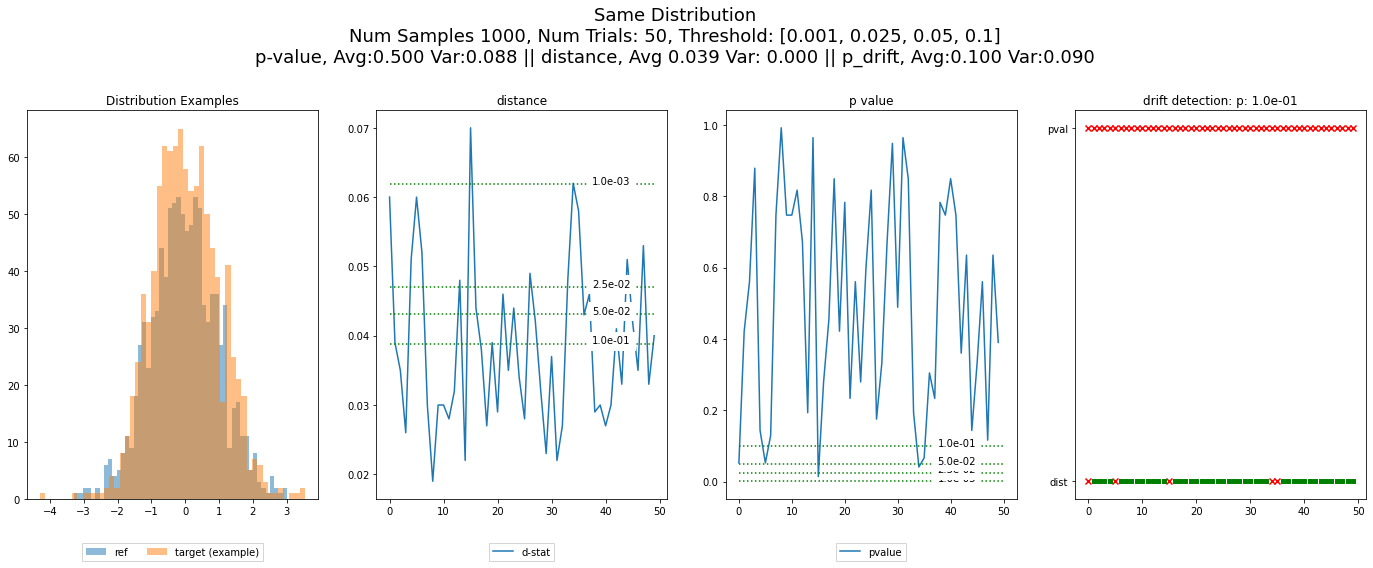

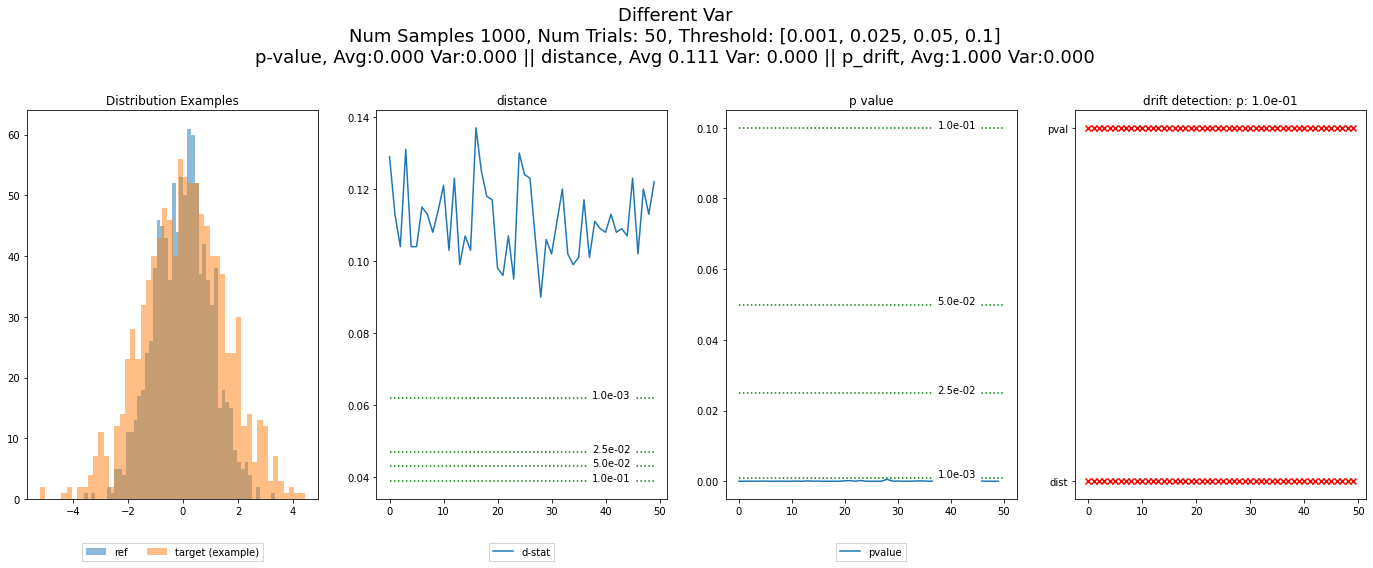

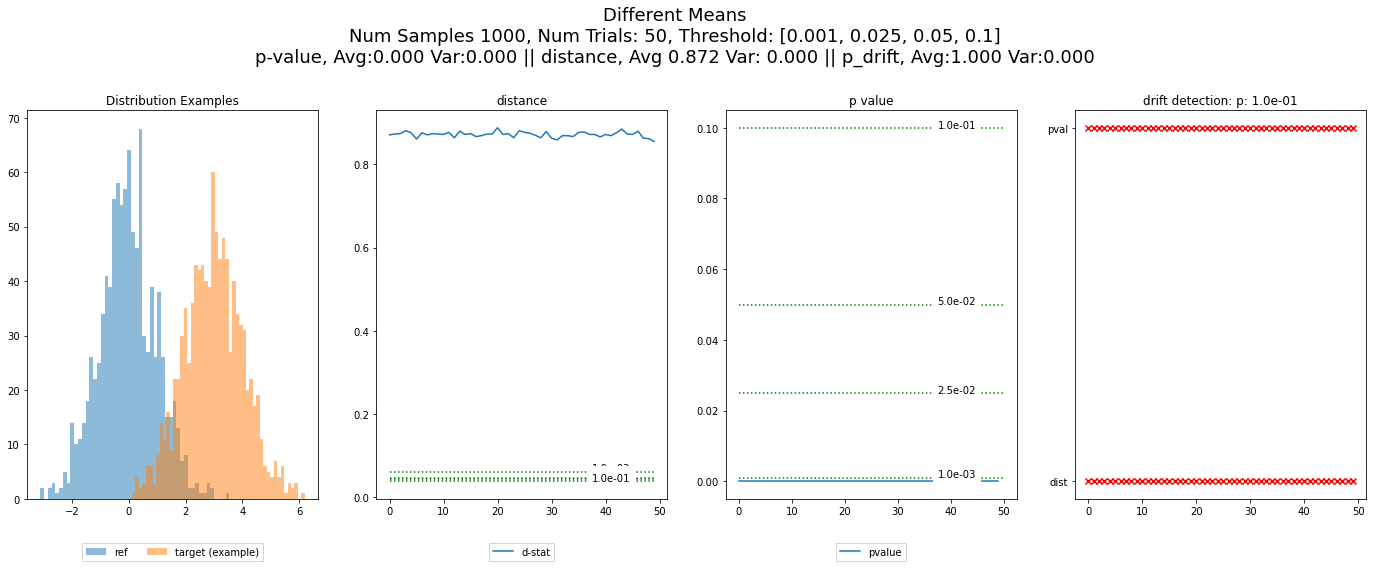

In [48]:
from alibi_detect.cd import TabularDrift, KSDrift, ChiSquareDrift

import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from scipy.stats import ks_2samp
from numpy.random import randn
from numpy.random import lognormal

from scipy.special import kolmogi

def calc_critical_value(n1, n2, q=.01):
    if n2 == 0:
        return None
    return kolmogi(q)*np.sqrt((n1+n2)/(n1*n2))


def alibi_ksdrift_test(ref_dist=randn, target_dist=randn, num_samples = 2000, num_trials=25, q=(0.1, 0.05, 0.025, 0.001), name=None, p_pick=None):
    if not isinstance(q, Iterable):
            q = [q]
    q = list(q)
    if p_pick is None:
        p_pick = q[-1]
    q.append(p_pick)
    q = sorted(set(q))
    
    fig, (ax1, ax2, ax5, ax4) = plt.subplots(1, 4, figsize=(6*4, 8))
    ref = randn(num_samples)
    cd = MyKSDrift(ref, q_vals=q)
    
    ax1.hist(ref, alpha=0.5, label='ref', bins=50)
    ax1.hist(target_dist(num_samples), alpha=.5, label='target (example)', bins=50)
    ax1.legend()


    targets = [target_dist(num_samples) for _ in range(num_trials)]
    vals = [cd.predict(target) for target in targets]

    def merge_vals(ori):
        vals2 = defaultdict(lambda: np.array([]))
        for v in ori:
            for k, vv in v.items():
                vals2[k] = np.append(vals2[k], vv)
        return dict(vals2)
    vals = merge_vals(vals)
    # print(list(vals))

    ax5.plot(vals["p_val"], label='pvalue')
    ax2.plot(vals['distance'], label='d-stat')

    for qq in q:
        ax2.plot(range(num_trials), vals[('crit', qq)] , "g:")
        t = ax2.text(num_trials*3/4, vals[('crit', qq)][int(num_trials*.75)], f"{qq:1.1e}")
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

        ax5.plot([0, num_trials], [qq, qq] , "g:")
        t = ax5.text(num_trials*3/4, qq, f"{qq:1.1e}")
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    

    ax2.legend()
    # ax3.plot(our_drift_stat, label='our drift stat')
    # ax3.plot([0, num_trials], [0, 0], 'r', label='above_me_is_drift')

    x_vals = np.arange(0, num_trials)
    drift_pred_p = (vals['p_val'] < q[-1])
    p_drift, p_not_drift = x_vals[np.where(drift_pred_p)], x_vals[np.where(~drift_pred_p)]

    if len(p_drift):
        ax4.scatter(p_drift, np.zeros_like(p_drift), marker="x", color='red')
    if len(p_not_drift):
        ax4.scatter(p_not_drift,  np.zeros_like(p_not_drift), marker="s", color='green', s=20)

    drift_pred_crit = (vals[('crit', q[-1])] > 0)
    crit_drift, crit_not_drift = x_vals[np.where(drift_pred_crit)], x_vals[np.where(~drift_pred_crit)]

    if len(crit_drift):
        ax4.scatter(crit_drift, np.zeros_like(crit_drift)+1, marker="x", color='red')
    if len(crit_not_drift):
        ax4.scatter(crit_not_drift,  np.zeros_like(crit_not_drift)+1, marker="s", color='green', s=20)



    ax4.set_yticks([0, 1])
    ax4.set_yticklabels(["dist", "pval"])

    # cc=list(map(lambda x: 'red' if x > 0 else 'blue', alibi_is_drift))
    # ax4.bar(range(num_trials), np.ones(num_trials), label='alibi_drift', color=cc)
    # ax4.legend()
    # ax4.set_ylim([-0.1,1.1])
    ax1.set_title("Distribution Examples")
    ax2.set_title("distance")
    # ax3.set_title(f"soft drift stat (ours) q: {q[-1]:1.1e}")
    ax4.set_title(f"drift detection: p: {q[-1]:1.1e}")
    ax5.set_title("p value")

    title = []
    if name:
        title.append(str(name))

    title.append(f'Num Samples {num_samples}, Num Trials: {num_trials}, Threshold: {q}')
    

    minititle = [
        f"p-value, Avg:{np.mean(vals['p_val']):.3f} Var:{np.var(vals['p_val']):.3f}", 
        f"distance, Avg {np.mean(vals['distance']):.3f} Var: {np.var(vals['distance']):.3f}",
        f"p_drift, Avg:{np.mean(drift_pred_p):.3f} Var:{np.var(drift_pred_p):.3f}", 
        ]
    title.append(' || '.join(minititle))
    fig.suptitle('\n'.join(title), fontsize=18)
    fig.subplots_adjust(top=.8)
    
    for ax in (ax1, ax2, ax5, ):
        ax.legend(loc='upper center', 
                bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=2)
    plt.show()

    # crt = calc_critical_value(num_samples, num_samples, q=q)
    # vals = [cd.predict(target_dist(num_samples))['data'] for _ in range(num_trials)]
    # vals = [(val['distance'], val['p_val'], val['is_drift']) for val in vals] 
    # dstat, pvals, alibi_is_drift = zip(*vals)
    # is_drift = [d-crt for d in dstat]
    # ax1.set_title("(a) Distribution Examples")
    # ax2.set_title("(b) pvalue and distance")
    # ax3.set_title("(c) soft drift stat (ours)")
    # ax4.set_title("(d) alibi drift detection")
    # ax2.plot(pvals, label='pvalue')
    # ax2.plot(dstat, label='distance')
    # ax3.plot(is_drift, label='drift_stat')
    # ax3.plot([0, num_trials], [0, 0], 'r', label='above_me_is_drift')
    # cc=list(map(lambda x: 'red' if x > 0 else 'blue', alibi_is_drift))
    # ax4.bar(range(num_trials), np.ones(num_trials), label='alibi_drift', color=cc)
    # ax4.legend()
    # ax2.legend()
    # ax3.legend()
    # # ax4.legend()

    # title = []
    # if name:
    #     title.append(str(name))

    # title.append(f'Num Samples {num_samples}, Num Trials: {num_trials}, Threshold: {q}')

    # minititle = [
    #     f"p-value, Avg:{np.mean(pvals):.3f} Var:{np.var(pvals):.3f}", 
    #     f"distance, Avg {np.mean(dstat):.3f} Var: {np.var(dstat):.3f}",
    #     f"alibi_is_drift, Avg:{np.mean(alibi_is_drift):.3f} Var:{np.var(alibi_is_drift):.3f}", 
    #     ]
    # title.append(' || '.join(minititle))
    # fig.suptitle('\n'.join(title), fontsize=18)
    # fig.subplots_adjust(top=.8)
    
    # for ax in (ax1, ax2, ax3, ax4):
    #     ax.legend(loc='upper center', 
    #             bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=2)
    # plt.show()


num_samples = 1000
num_trials = 50
q=(0.1, 0.05, 0.025, 0.001)
alibi_ksdrift_test(name="Same Distribution", q=q, num_samples=num_samples, num_trials=num_trials,)
alibi_ksdrift_test(target_dist=lambda n: randn(n)*1.5, name="Different Var", q=q, num_samples=num_samples, num_trials=num_trials,)
alibi_ksdrift_test(target_dist=lambda n: randn(n)+3, name="Different Means", q=q, num_samples=num_samples, num_trials=num_trials,)

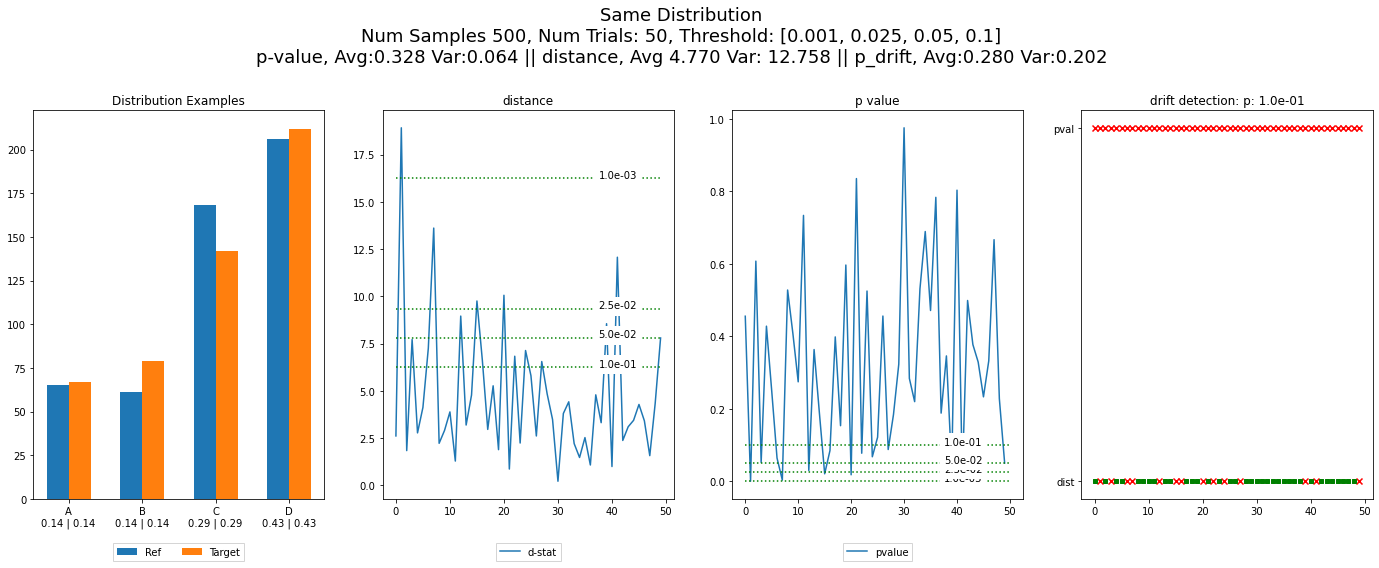

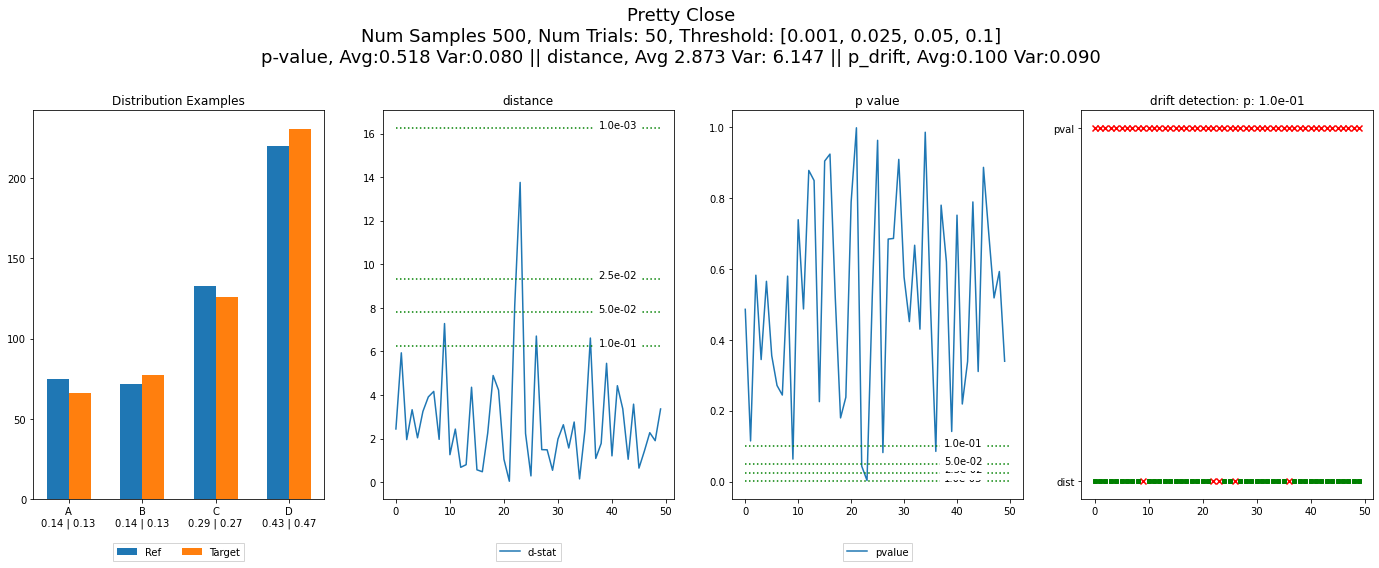

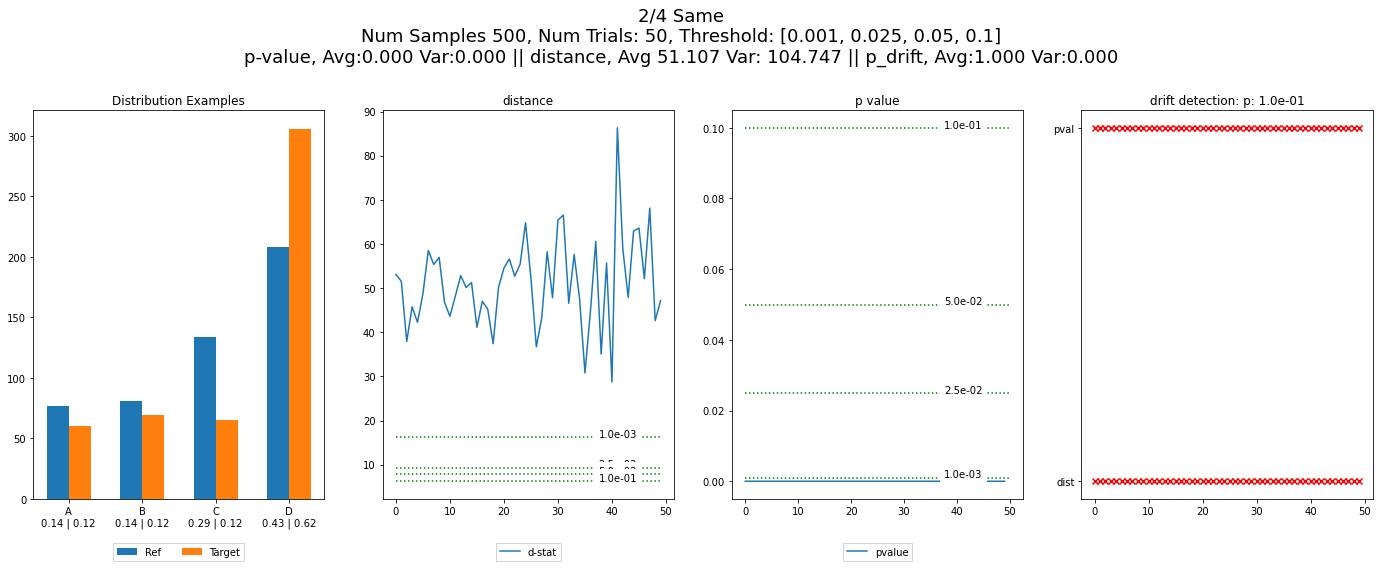

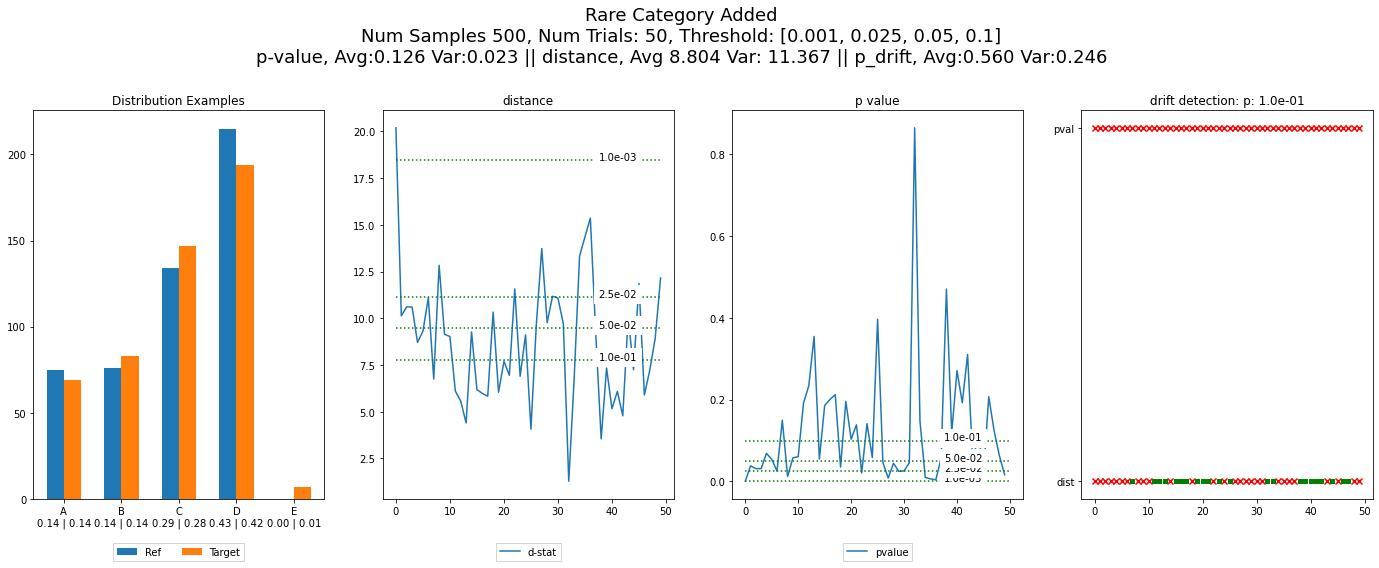

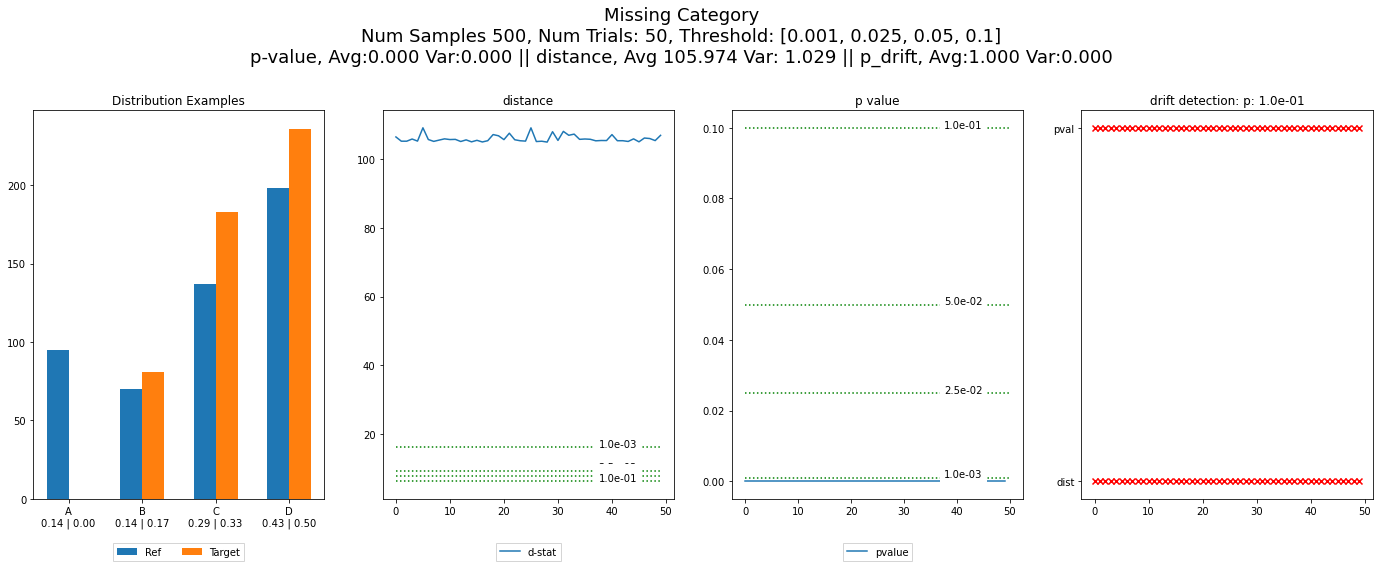

''

In [49]:
import random
from scipy.stats import chisquare, power_divergence, chi2_contingency
from scipy.stats import chi2
from collections import Counter, defaultdict
from collections.abc import Iterable

class MyChiSqDrift(object):

    def __init__(self, ref, correction=True, lambda_=None, q_vals=(0.1, 0.05, 0.025, 0.001)):
            self.ref_counts = Counter(ref)
            self.correction = correction
            self.lambda_ = lambda_
            self.q_vals = q_vals

    def predict(self, sample):
        sample_counts = Counter(sample)
        keys = set().union(self.ref_counts, sample_counts)

        exp = [self.ref_counts.get(k, 0) for k in keys]
        obs = [sample_counts.get(k, 0) for k in keys]

        out = {}
        out['distance'], out['p_val'], out['dof'], _ = chi2_contingency(np.vstack([exp, obs]), correction=self.correction, lambda_=self.lambda_)
        for qq in self.q_vals:
            out[('crit', qq)] = chi2.ppf(1-qq, out['dof'])
            out[('our_drift_stat', qq)] = out['distance'] - out[('crit', qq)]
        return out





def alibi_categorical_test(ref_dist: dict, target_dist=None, num_samples=2000, num_trials=5, test='chisquare', q=(0.1, 0.05, 0.025, 0.001), name=None, p_pick=None):
    
    if not isinstance(q, Iterable):
        q = [q]
    q = list(q)
    if p_pick is None:
        p_pick = q[-1]
    q.append(p_pick)
    q = sorted(set(q))
    nref = sum(ref_dist.values())
    ref_dist = {k:v/nref for k, v in ref_dist.items()}
    # testers = {"chisquare": chisquare, "my_test": my_test}
    target_dist = target_dist or ref_dist

    ntar = sum(target_dist.values())
    target_dist = {k:v/ntar for k, v in target_dist.items()}

    ref_dist_func = lambda nsamp: random.choices(
        list(ref_dist.keys()), list(ref_dist.values()), k=nsamp
    )
    target_dist_func = lambda nsamp: random.choices(
            list(target_dist.keys()), list(target_dist.values()), k=nsamp
        )
    keys = sorted(set(ref_dist.keys()).union(target_dist.keys()))

    def _get_obs(sample, normalize=True):
        count = Counter(sample)
        count = [count.get(k, 0) for k in keys]
        if normalize:
            return np.array(count)/sum(count)
        return count


    ref = np.array(ref_dist_func(num_samples))
    ref_count = _get_obs(ref, normalize=False)
    target_count = _get_obs(target_dist_func(num_samples), normalize=False)

    fig, (ax1, ax2, ax5, ax4) = plt.subplots(1, 4, figsize=(6*4, 8))

    x = np.arange(len(keys), dtype=int)
    width=0.3
    ax1.bar(x, ref_count, width=width, label='Ref')
    ax1.bar(x+width, target_count, width=width, label='Target')
    ax1.legend()
    ax1.set_xticks(x+width/2)
    ax1.set_xticklabels([f"{k}\n{ref_dist.get(k,0):.2f} | {target_dist.get(k,0):.2f}" for k in keys])

    f_exp = np.array(ref_count)/sum(ref_count)
    targets = [np.array(target_dist_func(num_samples)) for _ in range(num_trials)]
    cd = MyChiSqDrift(ref, q_vals=q)
    vals = [cd.predict(target) for target in targets]

    def merge_vals(ori):
        vals2 = defaultdict(lambda: np.array([]))
        for v in ori:
            for k, vv in v.items():
                vals2[k] = np.append(vals2[k], vv)
        return dict(vals2)
    vals = merge_vals(vals)

    ax5.plot(vals["p_val"], label='pvalue')
    ax2.plot(vals['distance'], label='d-stat')

    for qq in q:
        ax2.plot(range(num_trials), vals[('crit', qq)] , "g:")
        t = ax2.text(num_trials*3/4, vals[('crit', qq)][int(num_trials*.75)], f"{qq:1.1e}")
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

        ax5.plot([0, num_trials], [qq, qq] , "g:")
        t = ax5.text(num_trials*3/4, qq, f"{qq:1.1e}")
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    

    ax2.legend()
    # ax3.plot(our_drift_stat, label='our drift stat')
    # ax3.plot([0, num_trials], [0, 0], 'r', label='above_me_is_drift')



    x_vals = np.arange(0, num_trials)
    drift_pred_p = (vals['p_val'] < q[-1])
    p_drift, p_not_drift = x_vals[np.where(drift_pred_p)], x_vals[np.where(~drift_pred_p)]

    if len(p_drift):
        ax4.scatter(p_drift, np.zeros_like(p_drift), marker="x", color='red')
    if len(p_not_drift):
        ax4.scatter(p_not_drift,  np.zeros_like(p_not_drift), marker="s", color='green', s=20)

    drift_pred_crit = (vals[('crit', q[-1])] > 0)
    crit_drift, crit_not_drift = x_vals[np.where(drift_pred_crit)], x_vals[np.where(~drift_pred_crit)]

    if len(crit_drift):
        ax4.scatter(crit_drift, np.zeros_like(crit_drift)+1, marker="x", color='red')
    if len(crit_not_drift):
        ax4.scatter(crit_not_drift,  np.zeros_like(crit_not_drift)+1, marker="s", color='green', s=20)

    ax4.set_yticks([0, 1])
    ax4.set_yticklabels(["dist", "pval"])

    # cc=list(map(lambda x: 'red' if x > 0 else 'blue', alibi_is_drift))
    # ax4.bar(range(num_trials), np.ones(num_trials), label='alibi_drift', color=cc)
    # ax4.legend()
    # ax4.set_ylim([-0.1,1.1])
    ax1.set_title("Distribution Examples")
    ax2.set_title("distance")
    # ax3.set_title(f"soft drift stat (ours) q: {q[-1]:1.1e}")
    ax4.set_title(f"drift detection: p: {q[-1]:1.1e}")
    ax5.set_title("p value")

    title = []
    if name:
        title.append(str(name))

    title.append(f'Num Samples {num_samples}, Num Trials: {num_trials}, Threshold: {q}')
    

    minititle = [
        f"p-value, Avg:{np.mean(vals['p_val']):.3f} Var:{np.var(vals['p_val']):.3f}", 
        f"distance, Avg {np.mean(vals['distance']):.3f} Var: {np.var(vals['distance']):.3f}",
        f"p_drift, Avg:{np.mean(drift_pred_p):.3f} Var:{np.var(drift_pred_p):.3f}", 
        ]
    title.append(' || '.join(minititle))
    fig.suptitle('\n'.join(title), fontsize=18)
    fig.subplots_adjust(top=.8)
    
    for ax in (ax1, ax2, ax5, ):
        ax.legend(loc='upper center', 
                bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=2)
    plt.show()


ref_dist = dict(zip(["A", "B", "C", "D"], [1, 1, 2, 3]))
target_dist = None
num_samples = 500
num_trials = 50
q=.1



alibi_categorical_test(ref_dist, num_samples=num_samples, num_trials=num_trials, name='Same Distribution',)
alibi_categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [1, 1, 2, 3.5])), num_samples=num_samples, num_trials=num_trials, name='Pretty Close')
alibi_categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [1, 1, 1, 5])), num_samples=num_samples, num_trials=num_trials, name='2/4 Same')
# alibi_categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [3, 2, 1, 1])), num_samples=num_samples, num_trials=num_trials)


alibi_categorical_test(ref_dist, dict(zip(["A","B", "C", "D", "E"], [1, 1, 2, 3, .1])), num_samples=num_samples, num_trials=num_trials, name="Rare Category Added")
alibi_categorical_test(ref_dist, dict(zip(["B", "C", "D"], [1, 2, 3])), num_samples=num_samples, num_trials=num_trials, name="Missing Category")
# _ = alibi_categorical_test(ref_dist, dict(zip(["B", "C", "D"], [1, 2, 3])), num_samples=num_samples, num_trials=num_trials)

""

TypeError: _append_dispatcher() missing 1 required positional argument: 'values'

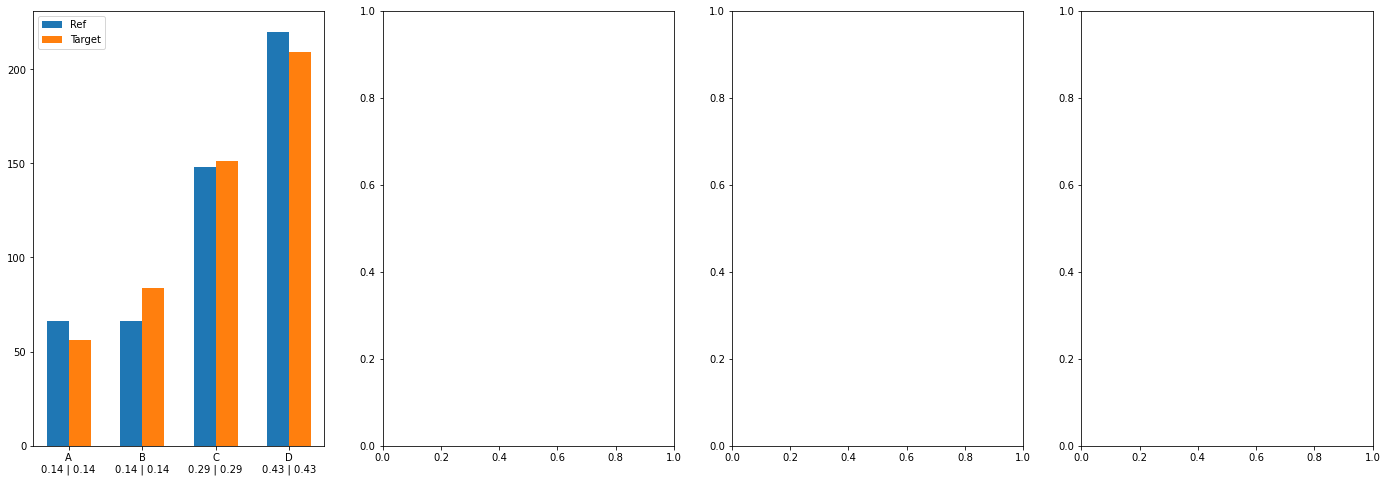

In [24]:
def compare_categorical_test(ref_dist: dict, target_dist=None, num_samples=2000, num_trials=5, test='chisquare', q=(0.1, 0.05, 0.025, 0.001), name=None):
    
    if not isinstance(q, Iterable):
        q = [q]

    nref = sum(ref_dist.values())
    ref_dist = {k:v/nref for k, v in ref_dist.items()}
    # testers = {"chisquare": chisquare, "my_test": my_test}
    target_dist = target_dist or ref_dist

    ntar = sum(target_dist.values())
    target_dist = {k:v/ntar for k, v in target_dist.items()}

    ref_dist_func = lambda nsamp: random.choices(
        list(ref_dist.keys()), list(ref_dist.values()), k=nsamp
    )
    target_dist_func = lambda nsamp: random.choices(
            list(target_dist.keys()), list(target_dist.values()), k=nsamp
        )
    keys = sorted(set(ref_dist.keys()).union(target_dist.keys()))

    def _get_obs(sample, normalize=True):
        count = Counter(sample)
        count = [count.get(k, 0) for k in keys]
        if normalize:
            return np.array(count)/sum(count)
        return count


    ref = np.array(ref_dist_func(num_samples))
    ref_count = _get_obs(ref, normalize=False)
    target_count = _get_obs(target_dist_func(num_samples), normalize=False)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(6*4, 8))

    x = np.arange(len(keys), dtype=int)
    width=0.3
    ax1.bar(x, ref_count, width=width, label='Ref')
    ax1.bar(x+width, target_count, width=width, label='Target')
    ax1.legend()
    ax1.set_xticks(x+width/2)
    ax1.set_xticklabels([f"{k}\n{ref_dist.get(k,0):.2f} | {target_dist.get(k,0):.2f}" for k in keys])

    f_exp = np.array(ref_count)/sum(ref_count)
    targets = [np.array(target_dist_func(num_samples)) for _ in range(num_trials)]


    def collect_and_plot(_apply, ax, label, show_qlines=False):
        vals = [_apply(target) for target in targets]
        vals2 = defaultdict(lambda: np.array([]))
        for v in vals:
            for k, vv in v.items():
                vals2[k] = np.append(vals2[k],)

        dstat, pvals, our_drift_stat,  alibi_is_drift = vals2['distance'], vals2["p_val"], vals2[('our_drift_stat', q[-1])], vals2['is_drift']
        ax.plot(pvals, label=label+'_'+'pvalue')
        ax.plot(dstat, label=label+'_'+'d-stat')

        if show_qlines:
            for qq in q:
                ax2.plot(range(num_trials), vals2[('crit', qq)] , "g", alpha=.1)
                t = ax2.text(num_trials*3/4, vals2[('crit', qq)][int(num_trials*.75)], f"{qq:1.1e}")
                t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
            ax2.legend()


    my_cd = MyChiSqDrift(ref, q_vals=q)
    _apply = my_cd.predict

    collect_and_plot(my_cd.predict, ax3, 'refactored', True)

    cd = ChiSquareDrift(ref, p_val=q[-1])
    def alibi_apply(target):
        out = cd.predict(target)['data']
        out["dof"] = dof = len(set().union(np.unique(ref), np.unique(target))) - 1
        for qq in q:
            out[('crit', qq)] = chi2.ppf(1-qq, dof)
            out[('our_drift_stat', qq)] = out['distance'] - out[('crit', qq)]
        return out

    collect_and_plot(alibi_apply, ax2, 'alibi', True)

    # ax3.plot(our_drift_stat, label='our drift stat')
    # ax3.plot([0, num_trials], [0, 0], 'r', label='above_me_is_drift')
    # cc=list(map(lambda x: 'red' if x > 0 else 'blue', alibi_is_drift))
    # ax4.bar(range(num_trials), np.ones(num_trials), label='alibi_drift', color=cc)
    # ax4.legend()
    # ax4.set_ylim([-0.1,1.1])
    ax1.set_title("(a) Distribution Examples")
    ax2.set_title("(b) pvalue and distance")
    ax3.set_title(f"(c) soft drift stat (ours) q: {q[-1]:1.1e}")
    ax4.set_title(f"(d) alibi drift detection: p: {q[-1]:1.1e}")

    title = []
    if name:
        title.append(str(name))

    title.append(f'Num Samples {num_samples}, Num Trials: {num_trials}, Threshold: {q}')
    

    minititle = [
        # f"p-value, Avg:{np.mean(pvals):.3f} Var:{np.var(pvals):.3f}", 
        # f"distance, Avg {np.mean(dstat):.3f} Var: {np.var(dstat):.3f}",
        # f"alibi_is_drift, Avg:{np.mean(alibi_is_drift):.3f} Var:{np.var(alibi_is_drift):.3f}", 
        ]
    title.append(' || '.join(minititle))
    fig.suptitle('\n'.join(title), fontsize=18)
    fig.subplots_adjust(top=.8)
    
    for ax in (ax1, ax2, ax3, ax4):
        ax.legend(loc='upper center', 
                bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=2)
    plt.show()


compare_categorical_test(ref_dist, num_samples=num_samples, num_trials=num_trials, name='Same Distribution',)

In [ ]:
num_samples = 1000
num_trials = 50
q = 0.1
alibi_ksdrift_test(name="Same Distribution", q=q, num_samples=num_samples, num_trials=num_trials,)
_ = alibi_categorical_test(ref_dist, num_samples=num_samples, num_trials=num_trials, name='Same Distribution', q=q)

In [ ]:
q = 0.001
alibi_ksdrift_test(name="Same Distribution", q=q, num_samples=num_samples, num_trials=num_trials,)
_ = alibi_categorical_test(ref_dist, num_samples=num_samples, num_trials=num_trials, name='Same Distribution', q=q)

In [ ]:
from alibi_detect.cd import LSDDDrift

def alibi_lsdd_categorical_test(ref_dist: dict, target_dist=None, num_samples=2000, num_trials=5, test='chisquare', q=(0.1, 0.05, 0.025, 0.001), name=None, p_pick=None):
    
    if not isinstance(q, Iterable):
        q = [q]
    q = list(q)
    if p_pick is None:
        p_pick = q[-1]
    q.append(p_pick)
    q = sorted(set(q))
    nref = sum(ref_dist.values())
    ref_dist = {k:v/nref for k, v in ref_dist.items()}
    # testers = {"chisquare": chisquare, "my_test": my_test}
    target_dist = target_dist or ref_dist

    ntar = sum(target_dist.values())
    target_dist = {k:v/ntar for k, v in target_dist.items()}


    keys = {k:float(i)  for i, k in enumerate(sorted(set(ref_dist.keys()).union(target_dist.keys())))}

    ref_dist_func = lambda nsamp: random.choices(
        [keys[k] for k in ref_dist.keys()], list(ref_dist.values()), k=nsamp
    )
    target_dist_func = lambda nsamp: random.choices(
            [keys[k] for k in target_dist.keys()], list(target_dist.values()), k=nsamp
        )

    ref = ref_dist_func(num_samples)
    cd = LSDDDrift(np.atleast_2d(np.array(ref)).T, backend='pytorch', data_type='tabular', n_permutations=100, p_val=p_pick)
    # out = cd.predict(np.atleast_2d(np.array(target_dist_func(num_samples))).T)

    # print(out)

    def _get_obs(sample, normalize=True):
        count = Counter(sample)
        count = [count.get(k, 0) for k in keys.values()]
        if normalize:
            return np.array(count)/sum(count)
        return count

    ref_count = _get_obs(ref, normalize=True)
    target_count = _get_obs(target_dist_func(num_samples), normalize=True)

    fig, (ax1, ax2, ax5) = plt.subplots(1, 3, figsize=(6*3, 8))

    x = np.arange(len(keys), dtype=int)
    width=0.3
    ax1.bar(x, ref_count, width=width, label='Ref')
    ax1.bar(x+width, target_count, width=width, label='Target')
    ax1.legend()
    ax1.set_xticks(x+width/2)
    ax1.set_xticklabels([f"{k}\n{ref_dist.get(k,0):.2f} | {target_dist.get(k,0):.2f}" for k in keys])

    # f_exp = np.array(ref_count)/sum(ref_count)
    targets = [np.atleast_2d(np.array(target_dist_func(num_samples))).T for _ in range(num_trials)]
    # cd = MyChiSqDrift(ref, q_vals=q)


    vals = [cd.predict(target)['data'] for target in targets]

    def merge_vals(ori):
        vals2 = defaultdict(lambda: np.array([]))
        for v in ori:
            for k, vv in v.items():
                vals2[k] = np.append(vals2[k], vv)
        return dict(vals2)
    vals = merge_vals(vals)

    ax5.plot(vals["p_val"], label='pvalue')
    ax2.plot(vals['distance'], label='distance')
    ax2.plot(vals['distance_threshold'], label='distance_threshold')
    # ax4.plot(vals['is_drift'], label='is_drift')

    # for qq in q:
    #     ax2.plot(range(num_trials), vals[('crit', qq)] , "g:")
    #     t = ax2.text(num_trials*3/4, vals[('crit', qq)][int(num_trials*.75)], f"{qq:1.1e}")
    #     t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    #     ax5.plot([0, num_trials], [qq, qq] , "g:")
    #     t = ax5.text(num_trials*3/4, qq, f"{qq:1.1e}")
    #     t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    

    # ax2.legend()
    # # ax3.plot(our_drift_stat, label='our drift stat')
    # # ax3.plot([0, num_trials], [0, 0], 'r', label='above_me_is_drift')

    x_vals = np.arange(0, num_trials)
    drift_pred_p = vals['is_drift']>0
    p_drift, p_not_drift = x_vals[np.where(drift_pred_p)], x_vals[np.where(~drift_pred_p)]
    p_drift_val, p_not_drift_val = vals["p_val"][np.where(drift_pred_p)], vals["p_val"][np.where(~drift_pred_p)]

    if len(p_drift):
        ax5.scatter(p_drift, p_drift_val, marker="x", color='red')
    if len(p_not_drift):
        ax5.scatter(p_not_drift,  p_not_drift_val, marker=".", color='green', s=100)

    ax5.plot([0, num_trials], [p_pick, p_pick] , "r", alpha=0.5)
    t = ax5.text(num_trials*3/4, p_pick, f"{p_pick:1.1e}")
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


    x_vals = np.arange(0, num_trials)
    drift_pred_p = (vals['distance']>vals['distance_threshold'])
    p_drift, p_not_drift = x_vals[np.where(drift_pred_p)], x_vals[np.where(~drift_pred_p)]
    p_drift_val, p_not_drift_val = vals["distance"][np.where(drift_pred_p)], vals["distance"][np.where(~drift_pred_p)]

    if len(p_drift):
        ax2.scatter(p_drift, p_drift_val, marker="x", color='red')
    if len(p_not_drift):
        ax2.scatter(p_not_drift,  p_not_drift_val, marker=".", color='green', s=100)

    # ax2.plot([0, num_trials], [p_pick, p_pick] , "r", alpha=0.5)
    # t = ax2.text(num_trials*3/4, p_pick, f"{p_pick:1.1e}")
    # t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    # drift_pred_crit = (vals[('crit', q[-1])] > 0)
    # crit_drift, crit_not_drift = x_vals[np.where(drift_pred_crit)].squeeze(), x_vals[np.where(~drift_pred_crit)].squeeze()

    # if len(crit_drift):
    #     ax4.scatter(crit_drift, np.zeros_like(crit_drift)+1, marker="x", color='red')
    # if len(crit_not_drift):
    #     ax4.scatter(crit_not_drift,  np.zeros_like(crit_not_drift)+1, marker="s", color='green', s=20)



    # ax4.set_yticks([0, 1])
    # ax4.set_yticklabels(["dist", "pval"])

    # # cc=list(map(lambda x: 'red' if x > 0 else 'blue', alibi_is_drift))
    # # ax4.bar(range(num_trials), np.ones(num_trials), label='alibi_drift', color=cc)
    # # ax4.legend()
    # # ax4.set_ylim([-0.1,1.1])
    ax1.set_title("Distribution Examples")
    ax2.set_title("distance")
    # # ax3.set_title(f"soft drift stat (ours) q: {q[-1]:1.1e}")
    # ax4.set_title(f"drift detection: p: {q[-1]:1.1e}")
    ax5.set_title("p value")

    title = []
    if name:
        title.append(str(name))

    title.append(f'Num Samples {num_samples}, Num Trials: {num_trials}, Threshold: {q}')
    

    minititle = [
        f"p-value, Avg:{np.mean(vals['p_val']):.3f} Var:{np.var(vals['p_val']):.3f}", 
        f"distance, Avg {np.mean(vals['distance']):.3f} Var: {np.var(vals['distance']):.3f}",
        f"p_drift, Avg:{np.mean(drift_pred_p):.3f} Var:{np.var(drift_pred_p):.3f}", 
        ]
    title.append('')
    title.append(' || '.join(minititle))
    fig.suptitle('\n'.join(title), fontsize=18)
    fig.subplots_adjust(top=.8)
    
    for ax in (ax1, ax2, ax5):
        ax.legend(loc='upper center', 
                bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=2)
    plt.show()


ref_dist = dict(zip(["A", "B", "C", "D"], [1, 1, 2, 3]))
target_dist = None
num_samples = 1000
num_trials = 25
q=.1



alibi_lsdd_categorical_test(ref_dist, num_samples=num_samples, num_trials=num_trials, name='Same Distribution',)
alibi_lsdd_categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [1, 1, 2, 3.5])), num_samples=num_samples, num_trials=num_trials, name='Pretty Close')
alibi_lsdd_categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [1, 1, 1, 5])), num_samples=num_samples, num_trials=num_trials, name='2/4 Same')
# alibi_lsdd_categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [3, 2, 1, 1])), num_samples=num_samples, num_trials=num_trials)


alibi_lsdd_categorical_test(ref_dist, dict(zip(["A","B", "C", "D", "E"], [1, 1, 2, 3, .1])), num_samples=num_samples, num_trials=num_trials, name="Rare Category Added")

ref_dist['A'] = 0.1
alibi_lsdd_categorical_test(ref_dist, dict(zip(["B", "C", "D"], [1, 2, 3])), num_samples=num_samples, num_trials=num_trials, name="Rare Category Missing")
# _ = alibi_lsdd_categorical_test(ref_dist, dict(zip(["B", "C", "D"], [1, 2, 3])), num_samples=num_samples, num_trials=num_trials)b

In [ ]:

class EuclideanDist(object):
    
    def __init__(self, ref):
        self.ref = ref
        self.ref_counts = Counter(ref)

    def predict(self, sample):
        sample_counts = Counter(sample)
        keys = set().union(self.ref_counts, sample_counts)
        exp = np.array([self.ref_counts.get(k, 0) for k in keys])
        obs = np.array([sample_counts.get(k, 0) for k in keys])


        f_exp = exp/exp.sum()
        f_obs = obs/obs.sum()
        out = {}
        out['distance'] = np.sqrt(np.power(f_exp-f_obs,2).sum())

        # out = {}
        # out['distance'], out['p_val'], out['dof'], _ = chi2_contingency(np.vstack([exp, obs]), correction=self.correction, lambda_=self.lambda_)
        # for qq in self.q_vals:
        #     out[('crit', qq)] = chi2.ppf(1-qq, out['dof'])
        #     out[('our_drift_stat', qq)] = out['distance'] - out[('crit', qq)]
        return out



def euclidean_categorical_test(ref_dist: dict, target_dist=None, num_samples=2000, num_trials=5, test='chisquare', q=(0.1, 0.05, 0.025, 0.001), name=None, p_pick=None):
    
    if not isinstance(q, Iterable):
        q = [q]
    q = list(q)
    if p_pick is None:
        p_pick = q[-1]
    q.append(p_pick)
    q = sorted(set(q))
    nref = sum(ref_dist.values())
    ref_dist = {k:v/nref for k, v in ref_dist.items()}
    # testers = {"chisquare": chisquare, "my_test": my_test}
    target_dist = target_dist or ref_dist

    ntar = sum(target_dist.values())
    target_dist = {k:v/ntar for k, v in target_dist.items()}


    keys = sorted(set(ref_dist.keys()).union(target_dist.keys()))

    ref_dist_func = lambda nsamp: random.choices(
        list(ref_dist.keys()), list(ref_dist.values()), k=nsamp
    )
    target_dist_func = lambda nsamp: random.choices(
            list(target_dist.keys()), list(target_dist.values()), k=nsamp
        )

    ref = ref_dist_func(num_samples)
    cd = EuclideanDist(ref)
    # out = cd.predict(np.atleast_2d(np.array(target_dist_func(num_samples))).T)

    # print(out)

    def _get_obs(sample, normalize=True):
        count = Counter(sample)
        count = [count.get(k, 0) for k in keys]
        if normalize:
            return np.array(count)/sum(count)
        return count

    ref_count = _get_obs(ref, normalize=True)
    target_count = _get_obs(target_dist_func(num_samples), normalize=True)

    fig, (ax1, ax2, ax5) = plt.subplots(1, 3, figsize=(6*3, 8))

    x = np.arange(len(keys), dtype=int)
    width=0.3
    ax1.bar(x, ref_count, width=width, label='Ref')
    ax1.bar(x+width, target_count, width=width, label='Target')
    ax1.legend()
    ax1.set_xticks(x+width/2)
    ax1.set_xticklabels([f"{k}\n{ref_dist.get(k,0):.2f} | {target_dist.get(k,0):.2f}" for k in keys])

    # f_exp = np.array(ref_count)/sum(ref_count)
    targets = [target_dist_func(num_samples) for _ in range(num_trials)]
    # cd = MyChiSqDrift(ref, q_vals=q)


    vals = [cd.predict(target) for target in targets]

    def merge_vals(ori):
        vals2 = defaultdict(lambda: np.array([]))
        for v in ori:
            for k, vv in v.items():
                vals2[k] = np.append(vals2[k], vv)
        return dict(vals2)
    vals = merge_vals(vals)

    # ax5.plot(vals["p_val"], label='pvalue')
    ax2.plot(vals['distance'], label='distance')
    # ax2.plot(vals['distance_threshold'], label='distance_threshold')
    # ax4.plot(vals['is_drift'], label='is_drift')

    # for qq in q:
    #     ax2.plot(range(num_trials), vals[('crit', qq)] , "g:")
    #     t = ax2.text(num_trials*3/4, vals[('crit', qq)][int(num_trials*.75)], f"{qq:1.1e}")
    #     t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    #     ax5.plot([0, num_trials], [qq, qq] , "g:")
    #     t = ax5.text(num_trials*3/4, qq, f"{qq:1.1e}")
    #     t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    

    # ax2.legend()
    # # ax3.plot(our_drift_stat, label='our drift stat')
    # # ax3.plot([0, num_trials], [0, 0], 'r', label='above_me_is_drift')

    # x_vals = np.arange(0, num_trials)
    # drift_pred_p = vals['is_drift']>0
    # p_drift, p_not_drift = x_vals[np.where(drift_pred_p)], x_vals[np.where(~drift_pred_p)]
    # p_drift_val, p_not_drift_val = vals["p_val"][np.where(drift_pred_p)], vals["p_val"][np.where(~drift_pred_p)]

    # if len(p_drift):
    #     ax5.scatter(p_drift, p_drift_val, marker="x", color='red')
    # if len(p_not_drift):
    #     ax5.scatter(p_not_drift,  p_not_drift_val, marker=".", color='green', s=100)

    # ax5.plot([0, num_trials], [p_pick, p_pick] , "r", alpha=0.5)
    # t = ax5.text(num_trials*3/4, p_pick, f"{p_pick:1.1e}")
    # t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


    # x_vals = np.arange(0, num_trials)
    # drift_pred_p = (vals['distance']>vals['distance_threshold'])
    # p_drift, p_not_drift = x_vals[np.where(drift_pred_p)], x_vals[np.where(~drift_pred_p)]
    # p_drift_val, p_not_drift_val = vals["distance"][np.where(drift_pred_p)], vals["distance"][np.where(~drift_pred_p)]

    # if len(p_drift):
    #     ax2.scatter(p_drift, p_drift_val, marker="x", color='red')
    # if len(p_not_drift):
    #     ax2.scatter(p_not_drift,  p_not_drift_val, marker=".", color='green', s=100)

    # ax2.plot([0, num_trials], [p_pick, p_pick] , "r", alpha=0.5)
    # t = ax2.text(num_trials*3/4, p_pick, f"{p_pick:1.1e}")
    # t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

    # drift_pred_crit = (vals[('crit', q[-1])] > 0)
    # crit_drift, crit_not_drift = x_vals[np.where(drift_pred_crit)].squeeze(), x_vals[np.where(~drift_pred_crit)].squeeze()

    # if len(crit_drift):
    #     ax4.scatter(crit_drift, np.zeros_like(crit_drift)+1, marker="x", color='red')
    # if len(crit_not_drift):
    #     ax4.scatter(crit_not_drift,  np.zeros_like(crit_not_drift)+1, marker="s", color='green', s=20)



    # ax4.set_yticks([0, 1])
    # ax4.set_yticklabels(["dist", "pval"])

    # # cc=list(map(lambda x: 'red' if x > 0 else 'blue', alibi_is_drift))
    # # ax4.bar(range(num_trials), np.ones(num_trials), label='alibi_drift', color=cc)
    # # ax4.legend()
    # # ax4.set_ylim([-0.1,1.1])
    ax1.set_title("Distribution Examples")
    ax2.set_title("distance")
    # # ax3.set_title(f"soft drift stat (ours) q: {q[-1]:1.1e}")
    # ax4.set_title(f"drift detection: p: {q[-1]:1.1e}")
    ax5.set_title("p value")

    title = []
    if name:
        title.append(str(name))

    title.append(f'Num Samples {num_samples}, Num Trials: {num_trials}, Threshold: {q}')
    

    minititle = [
        # f"p-value, Avg:{np.mean(vals['p_val']):.3f} Var:{np.var(vals['p_val']):.3f}", 
        f"distance, Avg {np.mean(vals['distance']):.3f} Var: {np.var(vals['distance']):.3f}",
        # f"p_drift, Avg:{np.mean(drift_pred_p):.3f} Var:{np.var(drift_pred_p):.3f}", 
        ]
    title.append('')
    title.append(' || '.join(minititle))
    fig.suptitle('\n'.join(title), fontsize=18)
    fig.subplots_adjust(top=.8)
    
    for ax in (ax1, ax2, ax5):
        ax.legend(loc='upper center', 
                bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=2)
    plt.show()


ref_dist = dict(zip(["A", "B", "C", "D"], [1, 1, 2, 3]))
target_dist = None
num_samples = 1000
num_trials = 25
q=.1



euclidean_categorical_test(ref_dist, num_samples=num_samples, num_trials=num_trials, name='Same Distribution',)
euclidean_categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [1, 1, 2, 3.5])), num_samples=num_samples, num_trials=num_trials, name='Pretty Close')
euclidean_categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [1, 1, 1, 5])), num_samples=num_samples, num_trials=num_trials, name='2/4 Same')
# alibi_lsdd_categorical_test(ref_dist, dict(zip(["A", "B", "C", "D"], [3, 2, 1, 1])), num_samples=num_samples, num_trials=num_trials)


euclidean_categorical_test(ref_dist, dict(zip(["A","B", "C", "D", "E"], [1, 1, 2, 3, .1])), num_samples=num_samples, num_trials=num_trials, name="Rare Category Added")

ref_dist['A'] = 0.1
euclidean_categorical_test(ref_dist, dict(zip(["B", "C", "D"], [1, 2, 3])), num_samples=num_samples, num_trials=num_trials, name="Rare Category Missing")
# _ = alibi_lsdd_categorical_test(ref_dist, dict(zip(["B", "C", "D"], [1, 2, 3])), num_samples=num_samples, num_trials=num_trials)

In [ ]:
x = np.array([])

x = np.append(x, 3)
np.append(x, 4)
x = np.append(x, 3)
np.append(x, 4)
x = np.append(x, 3)
np.append(x, 4)

In [ ]:
x[np.where(x==3)]

In [ ]:
ref_dist_func = lambda nsamp: random.choices(
        list(ref_dist.keys()), list(ref_dist.values()), k=nsamp
    )
target_dist_func = lambda nsamp: random.choices(
        list(target_dist.keys()), list(target_dist.values()), k=nsamp
    )

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
import pandas as pd


In [ ]:


fig, ax = plt.subplots(figsize=(10, 8))
data1 = pd.DataFrame(np.random.randn(5000), columns=['data']).assign(source="Ref")
data2 = pd.DataFrame(np.random.randn(1000), columns=['data']).assign(source="Moving")


df = pd.concat([data1, data2]).reset_index()

sns.histplot(df, x='data', hue='source', kde=True, stat='percent', common_norm=False)
# sns.displot(data2)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
df = []
df.append(pd.DataFrame(np.random.randn(400)*.1, columns=['data']).assign(source="Ref"))

N = 50
step = 1
d =  N-np.arange(-N//2, N//2, step=step)**2
d -= min(d)
d = d/max(d)*.3
d += np.random.randn(d.shape[0])*.1
df.append(pd.DataFrame(d, columns=['data']).assign(source="Ref"))



# df.append(pd.DataFrame(np.random.randn(500)*1.3+5, columns=['data']).assign(source="Moving"))
# df.append(pd.DataFrame(np.random.randn(500)*1.3+5, columns=['data']).assign(source="Moving"))
# df.append(pd.DataFrame(np.random.randn(500)*1.3+2, columns=['data']).assign(source="Moving"))
df.append(pd.DataFrame(np.random.randn(300)*.1, columns=['data']).assign(source="Ref"))
# df.append(pd.DataFrame(np.random.randn(50)*1.3+2, columns=['data']).assign(source="Moving"))


df = pd.concat(df).reset_index()

dfr = df.ewm(span = 60)[['data']].mean().iloc[100:]
# dfr = df.rolling(25)[['data']].mean()#.reset_index()
dfr
sns.lineplot(x=dfr.index, y=dfr.data)
# sns.displot(data2)
ax.set_ylim([-.3, .3])

In [ ]:
N = 10
[i for i in np.arange(N//2, step=.5)]+[N//2-i for i in np.arange(N//2, step=.5)]

In [ ]:
import random

nsamp = 1000
nsamp2 = 100
ref_dist = {'Phillips': .8, "Siemens": .3, "GE": .5}
target_dist = dict(**ref_dist)

ref_dist_func = lambda nsamp: random.choices(
        list(ref_dist.keys()), list(ref_dist.values()), k=nsamp
    )
target_dist_func = lambda nsamp: random.choices(
            list(target_dist.keys()), list(target_dist.values()), k=nsamp
        )

df = []
df.append(pd.DataFrame(ref_dist_func(1000), columns=['Manufacturer']).assign(source='Ref'))
df.append(pd.DataFrame(target_dist_func(100), columns=['Manufacturer']).assign(source='Day2'))

df = pd.concat(df).reset_index()

fig, ax = plt.subplots(figsize=(10, 8))
sns.set_context('paper', font_scale=2)

sns.histplot(df, x='Manufacturer', hue='source', multiple="dodge", stat='percent', common_norm=False, shrink=.8, ax=ax)
# ax.get_legend().remove()